___
# Ume Challenge

> Nelson Buainain – February, 2022

___
## The problem

Acme is a retail company that sells different items to its customers. To increase its sales, it decided to grant credit to these customers based on an automatic risk model. More specifically, given various information about a customer C, obtained at the time of the credit request, the company wants to infer the risk associated with C. Risk is understood as the probability that C will not pay the debt he has acquired in the following months, thus becoming a bad payer.

To this end, Acme collected data from requesting customers during the months of August and September 2015, recording their performance as good or bad payers in subsequent months. In particular, for each customer, the company collected the following data:

* The credit request date (reference date);

* Demographic informations such as age, gender, etc;

* Client employment information;

* Income information;

* Information on past debt history

The customer's performance, as a good or bad payer, is recorded in the target column. In particular, a customer with target = 1 is considered a bad payer.

The data described in this section will be provided as an attachment with this statement.

___
## The data

| Nome da   Variável         | Descrição                                          | Tipo        |
|----------------------------|----------------------------------------------------|-------------|
| refdate                    | Data de referência (forma YYYY-MM-DD)              | Data        |
| demo_age                   | Idade                                              | Numérica    |
| demo_gender                | Gênero                                             | Categórica  |
| demo_marital_status        | Estado civil                                       | Categórica  |
|     demo_schooling         | Escolaridade                                       | Categórica  |
| demo_residence_time        | Tempo de residência                                | Numérica    |
| demo_residence_kind        | Tipo de residência                                 | Categórica  |
| job_formal                 | Tem emprego formal?                                | Lógica      |
| job_retired                | Aposentado?                                        | Lógica      |
| job_employment_time        | Tempo empregado                                    | Numérica    |
| job_kind                   | Tipo de emprego                                    | Categórica  |
| job_employment_experience  | Experiência em emprego                             | Categórica  |
| income_social_benefits     | Recebe auxílio social?                             | Lógica      |
| income_salary              | Salário declarado                                  | Numérica    |
| debt_profile               | Perfil como pagador                                | Categórica  |
| debt_prev_history          | Já foi mau pagador no mercado?                     | Lógica      |
| debt_bureau_score          | Escore de crédito no mercado (NaN = desconhecido)  | Numérica    |
| target                     | Mau pagador? (1 se mau pagador)                    | Lógica      |

___
## The challenge requirements

1. The proposed solution should be written on a Jupyter notebook, using the Python machine learning stack (sklearn and associated libraries) to build the proposed model.

2. The data from August 2015 (about 10000 clients) should be used to train the model, while the data from September 2015 (about 5000 clients) should be used to evaluate the performance of the model.

3. The notebook must include the entire data analysis, preparation and transformation process that is performed.

4. While any data preparation and prediction algorithms and techniques that the candidate considers appropriate to the analyses may be used, it is expected that **at least an ensemble approach** (eg random forests or boosting methods) should be tested.

5. Note that for the Acme company it is **essential to recognize bad debtors**, who are the **minority** of the population. Therefore, a **high accuracy is not necessarily the most adequate way to measure the performance** of the proposed method.

6. Also as part of the evaluation, the **importance of each of the attributes** used in the proposed model must be reported.

___
## The goal

Your task is to propose a predictive model using Python's sklearn-based machine learning stack that identifies bad payers

___
## Notebook Delivery

Após a criação do modelo, todos os códigos implementados e a avaliação do mesmo devem ser disponibilizados em um repositório público do github, através de um notebook Jupyter. No repositório, você pode incluir um arquivo README.MD para fornecer informações adicionais necessárias para a execução do seu notebook.

___
## The evaluation

Our technical team will clone the repository and evaluate the proposed model. After that, we will have a meeting with you, where you will discuss your technical decisions and answer any questions that our evaluators may still have. Note that all information in the notebook that helps in understanding models and decisions made will be welcome.

___
## Import modules

In [666]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report,fbeta_score,roc_auc_score,roc_curve,accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
import scikitplot as skplt
from scipy.stats import uniform, randint
from imblearn.over_sampling import SMOTE
import pickle

___
## Setup

In [2]:
%load_ext watermark
%watermark -v -m -p pandas,seaborn,matplotlib

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.24.0

pandas    : 1.2.4
seaborn   : 0.11.1
matplotlib: 3.4.2

Compiler    : Clang 6.0 (clang-600.0.57)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit



In [ ]:
## Generate requirements.txt file
# pip install pipreqsnb
# !pipreqsnb --force .

___
## Data processing

In [3]:
# Import database
data = pd.read_csv("./data/sample15k_synth_2022.csv")

### Data overview

**SUMMARY**

* most variables look ok and don't need processing

* debt_bureau_score has NaNs that can be filled in

* Categorical variables encoded as ordinal numbers might have be converted to dummies since the numerical differences in values among categories are not real but an artifact of enconding. This includes: demo_marital_status, demo_schooling, demo_residence_kind, job_kind, debt_profile

* I think that the demo_gender and debt_profile of -1 means missing information

* job_employment_time and and demo_residence_time have some outliers that might have to be removed

* refdates need to be converted to datetime

* target variables are unbalanced. It might be necessary to balance them using SMOTE

In [61]:
# General overview of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   refdate                    15000 non-null  object 
 1   demo_age                   15000 non-null  int64  
 2   demo_gender                15000 non-null  int64  
 3   demo_marital_status        15000 non-null  int64  
 4   demo_schooling             15000 non-null  int64  
 5   demo_residence_time        15000 non-null  int64  
 6   demo_residence_kind        15000 non-null  int64  
 7   job_formal                 15000 non-null  int64  
 8   job_retired                15000 non-null  int64  
 9   job_employment_time        15000 non-null  int64  
 10  job_kind                   15000 non-null  int64  
 11  job_employment_experience  15000 non-null  float64
 12  income_social_benefits     15000 non-null  int64  
 13  income_salary              15000 non-null  flo

In [4]:
# Convert refdate to datetime format
data['refdate'] = pd.to_datetime(data['refdate'])

In [39]:
# Look at some rows
# I can see we have some missing values for debt_bureau_score. I'll take a more careful look at that later
data.head()

,refdate,demo_age,demo_gender,demo_marital_status,demo_schooling,demo_residence_time,demo_residence_kind,job_formal,job_retired,job_employment_time,job_kind,job_employment_experience,income_social_benefits,income_salary,debt_profile,debt_prev_history,debt_bureau_score,target
0,2015-08-25,17,-1,1,4,12,1,0,0,19,2,1.0,0,1034.5000,-1,0,NaN,0
1,2015-08-12,25,1,1,4,60,1,1,0,0,2,0.0,0,1344.8500,0,0,0.8218,0
2,2015-08-08,40,1,1,3,98,1,1,0,0,4,0.0,0,2275.9000,2,0,0.9558,1
3,2015-08-14,29,0,1,5,108,1,0,0,30,2,1.0,0,1344.8500,5,0,0.9304,0
4,2015-08-28,19,-1,1,4,120,1,0,0,0,4,0.0,0,1008.6375,-1,0,NaN,0


In [380]:
# Screen to see if there is any anomalies in the descriptive statistics of the data
pd.options.display.float_format = '{:.3f}'.format
data.groupby('target').describe().T

target                                    0         1
demo_age                  count   11446.000  2482.000
                          mean       36.747    33.819
                          std        13.402    12.740
                          min        17.000    17.000
                          25%        26.000    23.000
                          50%        35.000    31.000
                          75%        46.000    42.000
                          max        81.000    81.000
demo_gender               count   11446.000  2482.000
                          mean        0.396     0.434
                          std         0.489     0.496
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%         0.000     0.000
                          75%         1.000     1.000
                          max         1.000     1.000
demo_residence_time       count   11446.000  2482.000
                          mean      137.922   128.423
                          std       131.086   134.549
                          min         0.000     0.000
                          25%        36.000    26.000
                          50%       113.000    85.000
                          75%       216.000   186.000
                          max      2460.000  2520.000
job_formal                count   11446.000  2482.000
                          mean        0.445     0.409
                          std         0.497     0.492
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%         0.000     0.000
                          75%         1.000     1.000
                          max         1.000     1.000
job_retired               count   11446.000  2482.000
                          mean        0.046     0.041
                          std         0.210     0.199
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%         0.000     0.000
                          75%         0.000     0.000
                          max         1.000     1.000
job_employment_time       count   11446.000  2482.000
                          mean       48.056    40.810
                          std        71.060    62.963
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%        20.000    18.000
                          75%        60.000    51.000
                          max       722.000   463.000
job_employment_experience count   11446.000  2482.000
                          mean        0.733     0.711
                          std         0.442     0.453
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%         1.000     1.000
                          75%         1.000     1.000
                          max         1.000     1.000
income_social_benefits    count   11446.000  2482.000
                          mean        0.090     0.087
                          std         0.286     0.282
                          min         0.000     0.000
                          25%         0.000     0.000
                          50%         0.000     0.000
                          75%         0.000     0.000
                          max         1.000     1.000
income_salary             count   11446.000  2482.000
                          mean     2168.418  1881.418
                          std      9905.144  1166.229
                          min       724.150   724.150
                          25%      1241.400  1241.400
                          50%      1551.750  1551.750
                          75%      2327.625  2069.000
                          max   1018982.500 16552.000
debt_prev_history         count   11446.000  2482.000
    

In [51]:
# Take a look at the distribution of the data in the different columns
# Gender: I'm assuming -1 represents unknown gender. It might be necessary to remove these samples since in practical terms these are NaN values
for i in list(data):
    print(f'{i}:\n {data[i].value_counts()}\n')

refdate:
 2015-08-11    925
2015-08-10    552
2015-08-18    551
2015-08-25    486
2015-08-09    456
             ... 
2015-09-16     61
2015-09-23     37
2015-08-05     36
2015-08-01     22
2015-08-02     12
Name: refdate, Length: 61, dtype: int64

demo_age:
 19    653
20    644
21    557
22    499
29    457
     ... 
74     10
77      8
78      6
81      6
80      5
Name: demo_age, Length: 65, dtype: int64

demo_gender:
  0    8481
 1    5727
-1     792
Name: demo_gender, dtype: int64

demo_marital_status:
 1    8029
2    5452
6     634
5     501
4     294
3      51
7      39
Name: demo_marital_status, dtype: int64

demo_schooling:
 4    7930
1    1867
2    1784
3    1611
5    1111
0     697
Name: demo_schooling, dtype: int64

demo_residence_time:
 120    1150
12      947
24      787
240     675
60      667
       ... 
164       1
196       1
212       1
284       1
487       1
Name: demo_residence_time, Length: 447, dtype: int64

demo_residence_kind:
 1    11748
2     2707
5      378

___
### Size of the dataset

**GOAL**

Evaluate the size of the dataset after partitioning in train and test datasets and by the different targets

**SUMMARY**

* It seems like there is enough data to build a decent model but it might be necessary to do some balacing in the data

In [128]:
# Make sure you only have data from 2015 and from months 8 and 9
print(data['refdate'].dt.year.value_counts())
print('\n')
print(data['refdate'].dt.month.value_counts())

2015    15000
Name: refdate, dtype: int64


8    10000
9     5000
Name: refdate, dtype: int64


In [5]:
# Keep only the month as reference
data['refdate'] = data['refdate'].dt.month

In [116]:
# Considering that the training data will be the month of August and the test date the month of September
# check how much data we have in the train and test sets considering each target

data[['refdate','target']].groupby(['refdate','target']).size()

refdate  target
8        0         8295
         1         1705
9        0         3974
         1         1026
dtype: int64

___
### Missing data report

**GOAL**

* See how much data we would lose by removing/inputing data into cell with missing values

**SUMMMARY**

* There is not much missing information in the dataset

* The ammount of missing data is relatively balanced among the two target categories and among train and test sets

* The ammount of missing data is not ideal but it seems like even if we adopt a conservative approach and remove most rows with missing data, we will still have enough data to train and evaluate a decent model

* Because missing data in debt_bureau_score represents only 3% of the total data and 5% of the bad payers data, and the distribution of the data looks ok. I'll replace NaN by the median value of the column. I chose the median because the outliers shown by the long tail in the histogram graphic suggests that the mean is not a good metric to be used here

* Removing rows with missing data in the debt_profile and demo_gender variables and inputing the column's median value to debt_bureau_scores we will lose about 1000 samples.

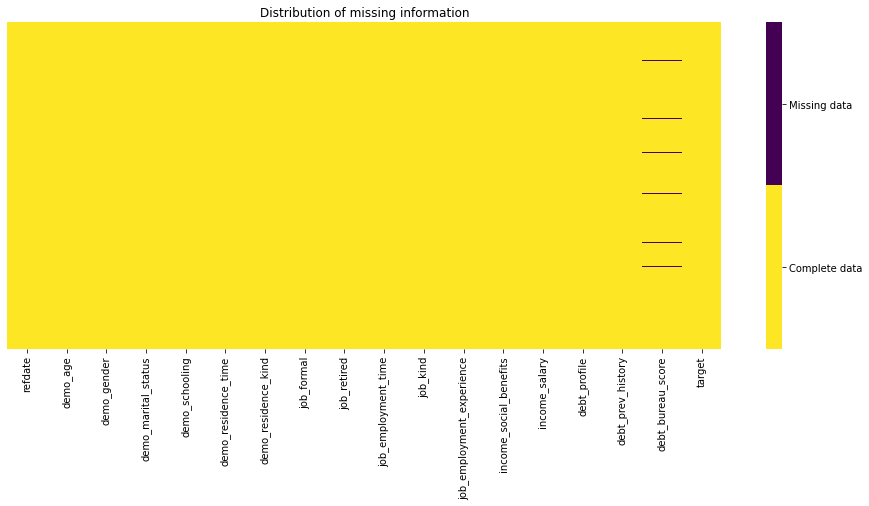

In [64]:
# Check how much missing data is present in a graphic
plt.figure(figsize=(16, 6))
ax = sns.heatmap(data.isnull(),yticklabels=False,cbar=True,cmap=['#FDE725FF','#440154FF'])
plt.title('Distribution of missing information')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.75, 0.25])
cbar.set_ticklabels(['Missing data', 'Complete data'])

* How does it look like for bay payers (i. e. target = 1)?

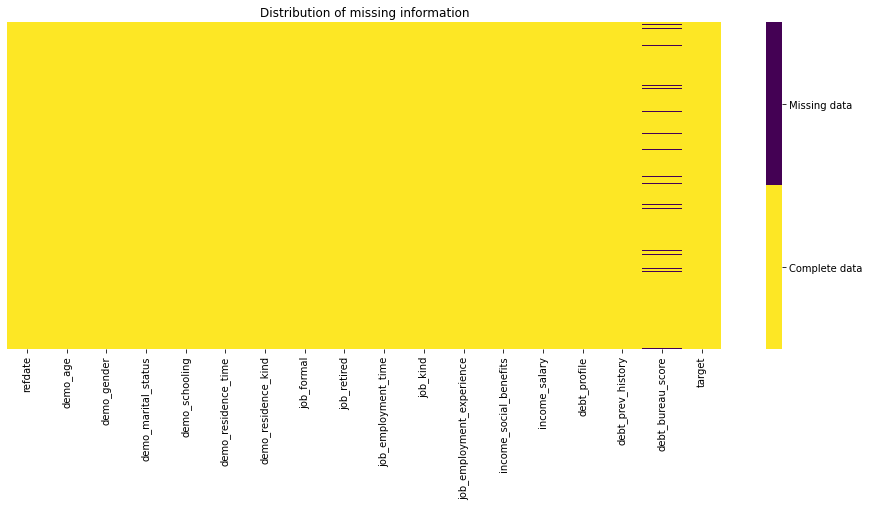

In [79]:
# Check how much missing data is present
plt.figure(figsize=(16, 6))
ax = sns.heatmap(data[data['target'] == 1].isnull(),yticklabels=False,cbar=True,cmap=['#FDE725FF','#440154FF'])
plt.title('Distribution of missing information')
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.75, 0.25])
cbar.set_ticklabels(['Missing data', 'Complete data'])

In [65]:
# Count how much missing data by column exists
data.isna().sum()

refdate                        0
demo_age                       0
demo_gender                    0
demo_marital_status            0
demo_schooling                 0
demo_residence_time            0
demo_residence_kind            0
job_formal                     0
job_retired                    0
job_employment_time            0
job_kind                       0
job_employment_experience      0
income_social_benefits         0
income_salary                  0
debt_profile                   0
debt_prev_history              0
debt_bureau_score            454
target                         0
dtype: int64

In [156]:
# Check how much missing data in the bad payers target dataset
print('Percentage of missing data on column "debt_bureau_score" for badpayers:')
print(round(data[data['target'] == 1]['debt_bureau_score'].isna().sum()/len(data[data['target'] == 1]),2))

Percentage of missing data on column "debt_bureau_score" for badpayers:
0.05


In [147]:
# Check how much data we would miss if we exclude samples with unknown gender
data['demo_gender'].value_counts()

 0    8481
 1    5727
-1     792
Name: demo_gender, dtype: int64

In [152]:
# How much would we loose in the badpayers dataset
print('Ammount of data to be lost')
print('In absolute numbers')
print(data[data['target'] == 1]['demo_gender'].value_counts())
print('In percentage')
print(data[data['target'] == 1]['demo_gender'].value_counts()/len(data[data['target'] == 1]))

In absolute numbers
 0    1428
 1    1101
-1     202
Name: demo_gender, dtype: int64
In percentage
 0    0.522885
 1    0.403149
-1    0.073966
Name: demo_gender, dtype: float64


In [157]:
# Check how much data we would miss if we exclude samples with unknown debt_profile
data['demo_gender'].value_counts()

 0    8481
 1    5727
-1     792
Name: demo_gender, dtype: int64

In [159]:
# Check how much would we loose in the badpayers dataset
print('In absolute numbers')
print(data[data['target'] == 1]['debt_profile'].value_counts())
print('In percentage')
print(data[data['target'] == 1]['debt_profile'].value_counts()/len(data[data['target'] == 1]))

In absolute numbers
 4    620
 0    587
 5    551
 3    474
 2    326
-1    166
 1      7
Name: debt_profile, dtype: int64
In percentage
 4    0.227023
 0    0.214940
 5    0.201758
 3    0.173563
 2    0.119370
-1    0.060784
 1    0.002563
Name: debt_profile, dtype: float64


In [166]:
# Check how much we would love in each column
print('Samples with missing data for debt_profile & demo_gender')
print(len(data[(data['debt_profile'] == -1) & (data['demo_gender'] == -1)]))
print('Samples with missing data only for debt_profile ')
print(len(data[(data['debt_profile'] == -1) & (data['demo_gender'] != -1)]))
print('Samples with missing data only for demo_gender ')
print(len(data[(data['debt_profile'] != -1) & (data['demo_gender'] == -1)]))

Samples with missing data for debt_profile & demo_gender
344
Samples with missing data only for debt_profile 
280
Samples with missing data only for demo_gender 
448


___
### Outlier report

**GOAL**

* Evaluate how many outliers we have in some features and if it is worth to remove them

**SUMMMARY**

* There aren't many outliers in the dataset (~170 samples)

* Because I'll likely start with a tree-based algorithms I think it won't be necessary to remove them

* I'll test the effect on the model of removing them to see if it makes any differece

* It might be necessary to exclude them if I end up choosin a different modeling approach

In [483]:
# Get upper limit quantile
job_emp_qtl = data['job_employment_time'].quantile(0.99)

# Count number of rows that are outliers
len(data[data['job_employment_time'] > job_emp_qtl])


140

In [484]:
# Get upper limit quantile
demo_res_qlt = data['demo_residence_time'].quantile(0.99)

# Count number of rows that are outliers
len(data[data['demo_residence_time'] > demo_res_qlt])


137

In [509]:
# Check how many of the outliers are shared among the two variables
len(data[(data['demo_residence_time'] > demo_res_qlt) & (data['job_employment_time'] > job_emp_qtl)])

6

___
### Data inputation

**GOAL**

* Replace NaN by column median value in debt_bureau_score

**SUMMARY**

* I've tested to fillna with the median values of debt_bureau_score and to drop the na rows in a preliminary model. Removing rows with nas resulted in a slightly better model so I'll skip this step

In [464]:
# data['debt_bureau_score'] = data['debt_bureau_score'].fillna(data['debt_bureau_score'].median())

___
### Drop NaNs

**GOAL**

* Drop rows with NaN (coded as -1) in the demo_gender and debt_profile

In [181]:
len(data)

15000

In [9]:
# Drop rows with -1 which I assume is missing data in the demo_gender and debt_profile columns
data = data[data['demo_gender'] != -1]
data = data[data['debt_profile'] != -1]
data = data.dropna(subset=['debt_bureau_score'])

In [183]:
len(data)

13928

___
### Get dummies

**GOALS**

* Transform categorical variables coded as ordinal numbers into binary

In [10]:
# Get a list of columns to be transformed to dummies
var_list_to_dummies = ['demo_marital_status', 'demo_schooling', 'demo_residence_kind', 'job_kind', 'debt_profile']

# Transform variables
data = pd.get_dummies(data,columns=var_list_to_dummies)

In [11]:
# Check if we have all the columns
list(data)

['refdate',
 'demo_age',
 'demo_gender',
 'demo_residence_time',
 'job_formal',
 'job_retired',
 'job_employment_time',
 'job_employment_experience',
 'income_social_benefits',
 'income_salary',
 'debt_prev_history',
 'debt_bureau_score',
 'target',
 'demo_marital_status_1',
 'demo_marital_status_2',
 'demo_marital_status_3',
 'demo_marital_status_4',
 'demo_marital_status_5',
 'demo_marital_status_6',
 'demo_marital_status_7',
 'demo_schooling_0',
 'demo_schooling_1',
 'demo_schooling_2',
 'demo_schooling_3',
 'demo_schooling_4',
 'demo_schooling_5',
 'demo_residence_kind_1',
 'demo_residence_kind_2',
 'demo_residence_kind_3',
 'demo_residence_kind_4',
 'demo_residence_kind_5',
 'job_kind_1',
 'job_kind_2',
 'job_kind_3',
 'job_kind_4',
 'job_kind_5',
 'job_kind_6',
 'job_kind_7',
 'job_kind_8',
 'job_kind_9',
 'debt_profile_0',
 'debt_profile_1',
 'debt_profile_2',
 'debt_profile_3',
 'debt_profile_4',
 'debt_profile_5']

In [200]:
# Check if all is ok in the data
data

,refdate,demo_age,demo_gender,demo_residence_time,job_formal,job_retired,job_employment_time,job_employment_experience,income_social_benefits,income_salary,...,job_kind_6,job_kind_7,job_kind_8,job_kind_9,debt_profile_0,debt_profile_1,debt_profile_2,debt_profile_3,debt_profile_4,debt_profile_5
1,8,25,1,60,1,0,0,0.0,0,1344.85,...,0,0,0,0,1,0,0,0,0,0
2,8,40,1,98,1,0,0,0.0,0,2275.90,...,0,0,0,0,0,0,1,0,0,0
3,8,29,0,108,0,0,30,1.0,0,1344.85,...,0,0,0,0,0,0,0,0,0,1
5,8,49,0,240,0,0,282,1.0,1,2586.25,...,0,0,0,0,0,0,1,0,0,0
6,8,68,0,300,1,0,0,0.0,0,7241.50,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,9,32,0,120,1,0,79,1.0,0,2793.15,...,0,0,0,0,0,0,0,0,1,0
14996,9,18,1,120,0,0,0,0.0,0,1034.50,...,0,0,0,0,1,0,0,0,0,0
14997,9,31,0,12,1,0,3,1.0,0,1551.75,...,0,0,0,0,0,0,0,0,0,1
14998,9,34,0,5,0,0,0,0.0,0,5172.50,...,0,0,0,0,0,0,0,1,0,0


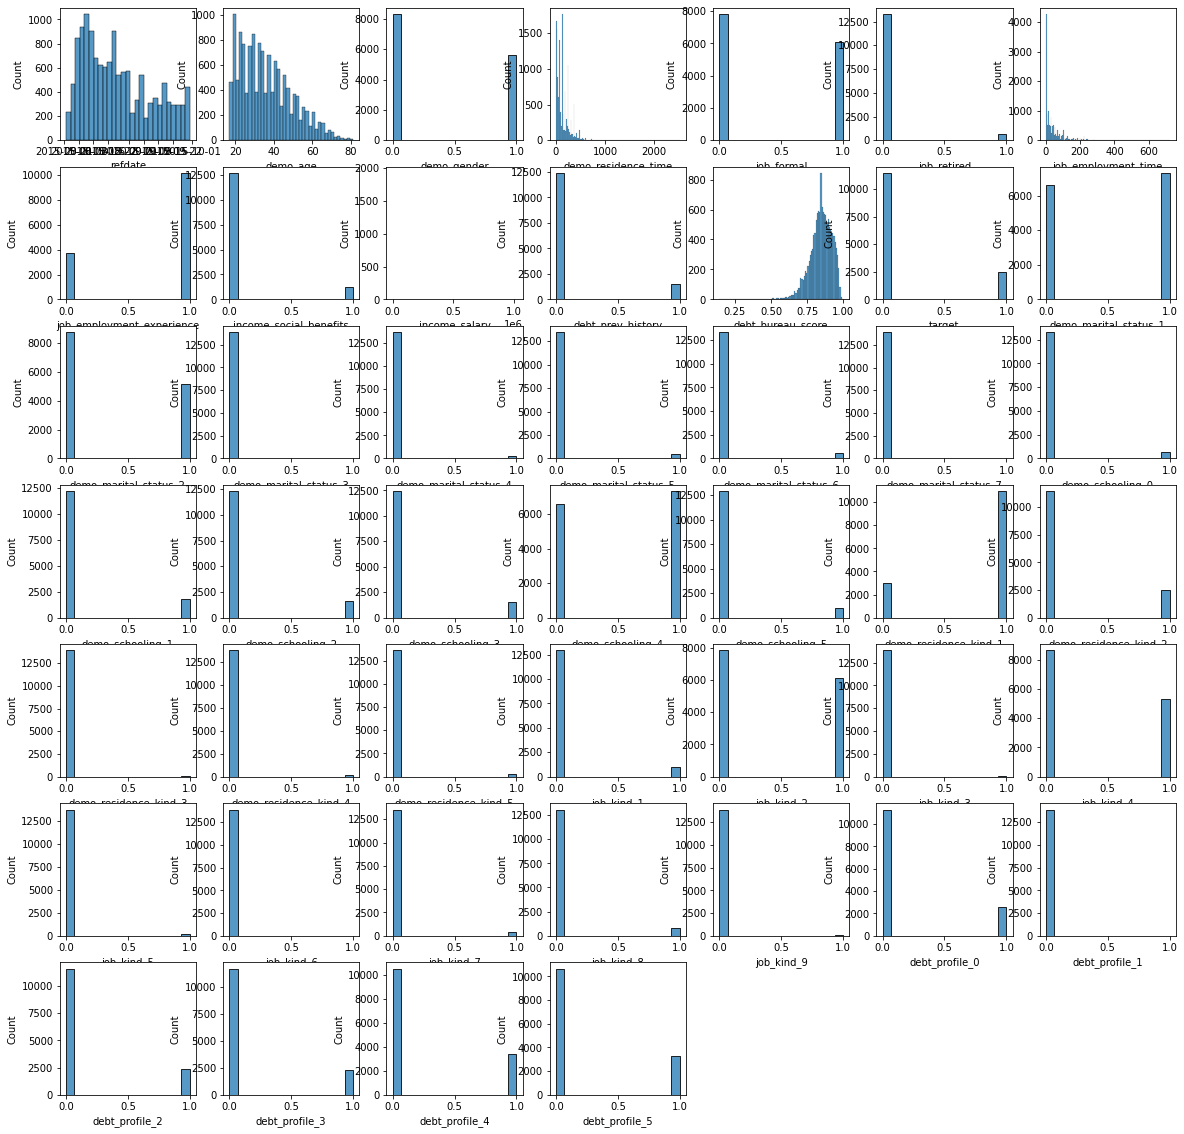

In [392]:
# Get a graphical general distribution of the data
plt.figure(figsize=(20,20))
for i, column in enumerate(data.columns, 1):
    plt.subplot(7,7,i)
    sns.histplot(data[column])

___
## Exploratory analysis

**GOALS**

* Evaluate if any of the features looks specially promising in separating the two targets

* Evaluate the possible correlation among variables that could be redundant in the model and decide if it is worth removing highly correalted variables

**SUMMARY**

* There is little or no correlation among most variables

* Only two variables had correlation coefficient > 0.8 -> 'demo_marital_status_2', 'demo_residence_kind_2'

* It is probably a good idea to test the effect of remove them during data modeling

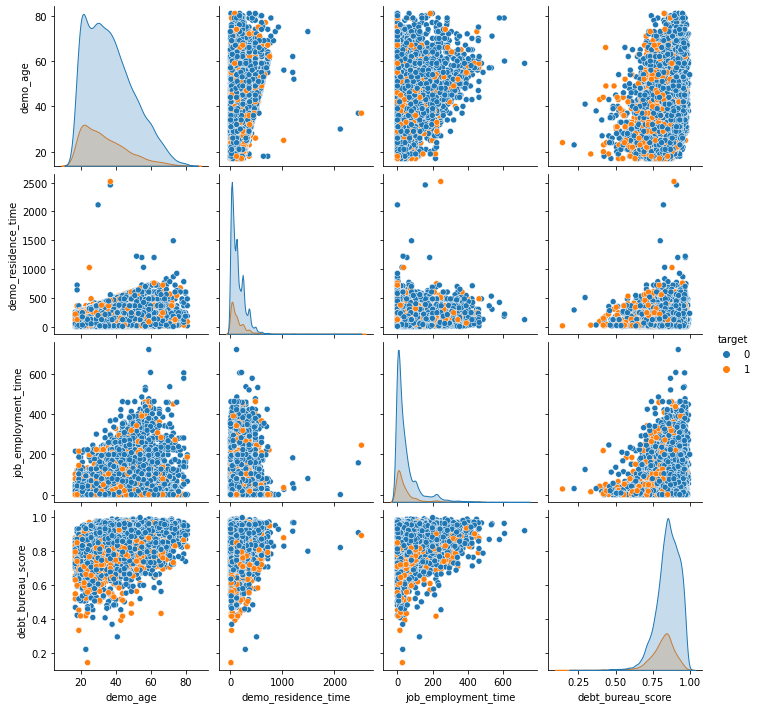

In [388]:
# Check distribution of continous variables colored by target
sns.pairplot(data[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','target']],hue='target')

The age distribution of bad payers might be a little skewerd toward the left suggesting that bad payers are usually younger



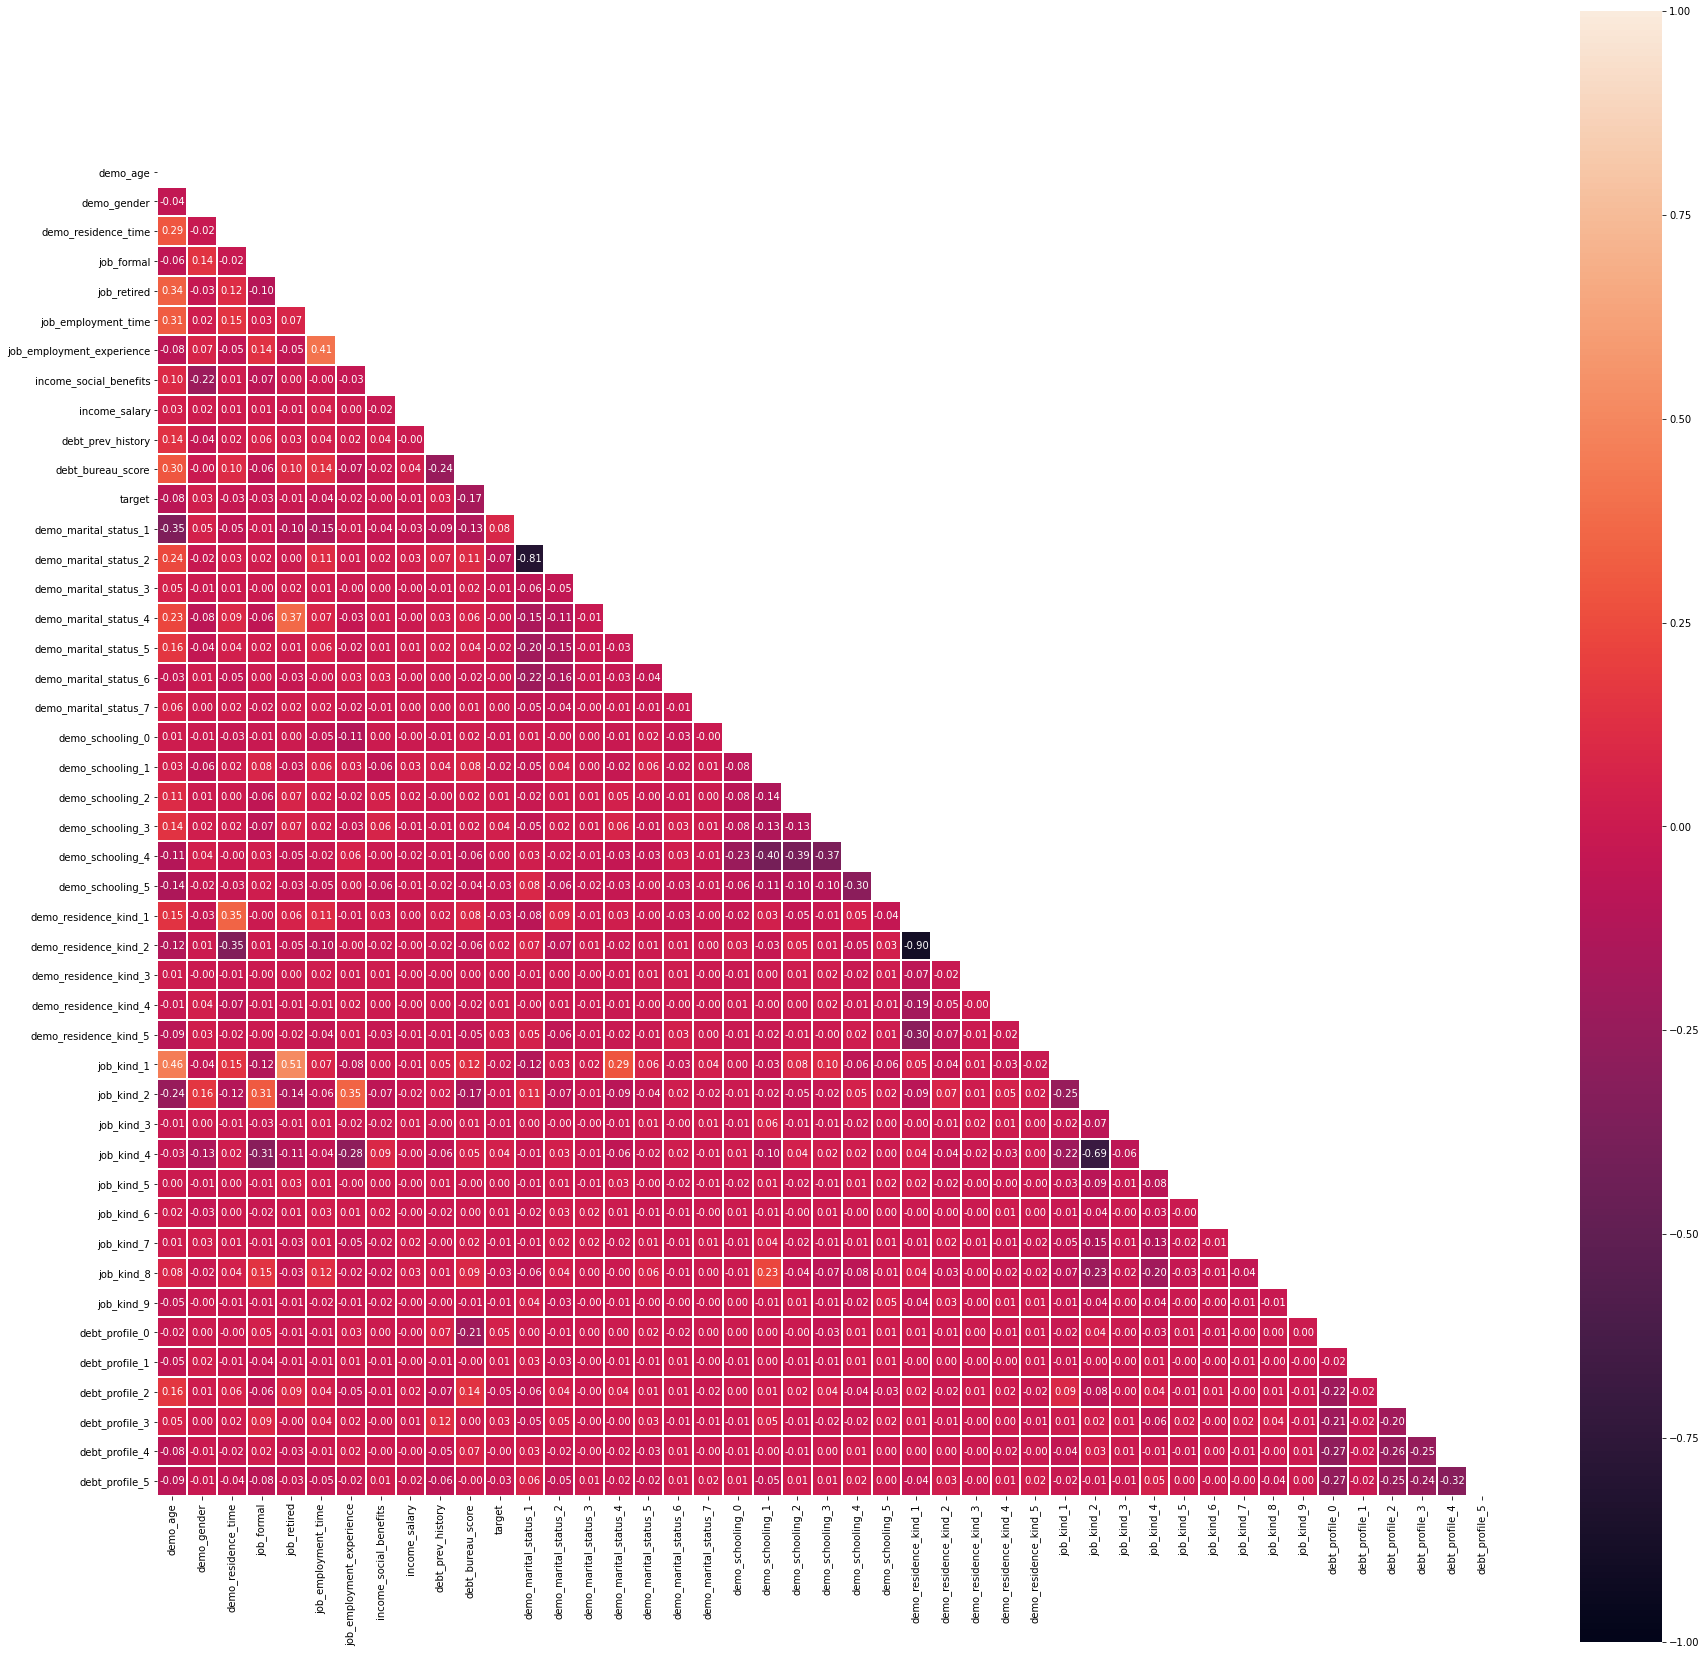

In [471]:
# Get a correlation heatmap of the variables
plt.figure(figsize=(30,30))
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, square=True, linecolor='white',linewidths=0.1,vmin=-1, vmax=1, annot=True, fmt='.2f');


In [476]:
## Get what variables are highly correlated

# Get correlation coefficients in absolute values
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
to_drop

['demo_marital_status_2', 'demo_residence_kind_2']

___
## Data modelling

>**GOALS**
>
>* Train a model that efficiently identifies bad payers
>
>**SUMMARY**

___
### Preliminary models

>**GOALS**
>
>* Test how basic treatments of the data affect a basic tree model. This includes:
>
>>1) balancing target variables
>2) feature selection 
>3) normalization
>4) reduction of dimensionality 
>5) removing uncorrelated variables
>6) removing outliers


>**SUMMARY**
>
>* None of the treatments above improved our model except for balacing the data
>* Balancing the data improved the detection of bad payers by 70% using important metrics such as the recall for the less favorable target
>* The lack of improvement with most treatment is possibly because the data was synthesized
>* A balanced dataset with no further treatment will be used in the future models

#### Plain Random Forest – Null Model

>**SUMMARY**
>* Train the null model and evaluate its perfomance
>
>* Our model performs poorly in identifying bad payers which is our main goal
>
>* Recall which is likely the most important metric for us looks terrible 

In [56]:
# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

In [57]:
# Check proportions of samples by target in the train and test sets
print(f'proportion of target 1/0 in train set: {y_train.value_counts()[1]/y_train.value_counts()[0]}')
print(f'proportion of target 1/0 in test set: {y_test.value_counts()[1]/y_test.value_counts()[0]}')

proportion of target 1/0 in train set: 0.19867204791042833
proportion of target 1/0 in test set: 0.2452361226180613


In [58]:
# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

In [59]:
# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      3621
           1       0.47      0.01      0.02       888

    accuracy                           0.80      4509
   macro avg       0.64      0.50      0.45      4509
weighted avg       0.74      0.80      0.72      4509

Fbeta: 0.77


#### 1) Random Forest with balanced data (SMOTE)

>**SUMMARY**
>
>* Balance the data significantly improved the model, especially the detection of bad payers
>
>* recall and f1 scores improved ~70% (from 0.02–70)

In [640]:
# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])
# Shuffle train set
X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])
# Shuffle Test set
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

In [641]:
# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

In [341]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.80273438 0.81977879 0.81770833 0.81184896 0.81119792]


In [342]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8126536746367383

<AxesSubplot:title={'center':'Learning Curve'}, xlabel='Training examples', ylabel='Score'>

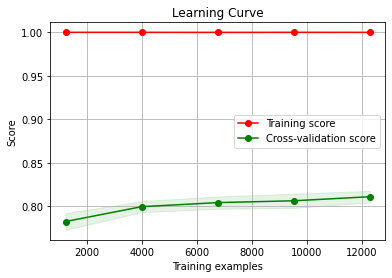

In [338]:
rf = RandomForestClassifier()
skplt.estimators.plot_learning_curve(rf, X_train, np.ravel(y_train),shuffle=True,scoring='recall',random_state=42,n_jobs=2)

In [642]:
# Evaluate the model with the test set
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.79      0.98      0.87      3621
           1       0.98      0.73      0.84      3621

    accuracy                           0.86      7242
   macro avg       0.88      0.86      0.86      7242
weighted avg       0.88      0.86      0.86      7242

Fbeta: 0.86


#### 2) Balanced Random Forest with Feature Selection

>**SUMMARY**
>
>* Dropping variable with less than a certain threshold of variable contribution score did not improve our model, on the contrary, it deteriorated it

In [80]:
# Expand df display to 50 rows
pd.options.display.max_rows = 50

# Get and show feature importance
feature_importance = pd.DataFrame(rf.feature_importances_,index=X_train.columns,columns=['feature_importance'])
feature_importance.sort_values(by='feature_importance',ascending=False)

,feature_importance
debt_bureau_score,0.118023
demo_residence_time,0.071736
demo_age,0.069085
income_salary,0.065044
job_employment_time,0.057337
demo_marital_status_2,0.050073
debt_profile_4,0.044267
debt_profile_5,0.042431
debt_profile_2,0.040842
demo_schooling_4,0.033851


<AxesSubplot:title={'center':'Feature Importance'}>

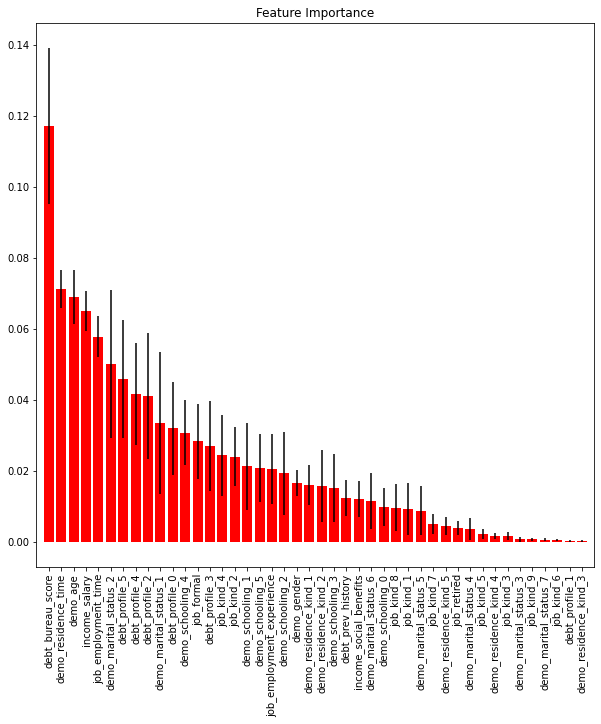

In [204]:
skplt.estimators.plot_feature_importances(rf, feature_names=X_train.columns,x_tick_rotation=90,max_num_features=50,figsize=(10,10))

In [82]:
# get a list of variables to drop in a conservative and more liberal approaches
threshold_1 = feature_importance[feature_importance['feature_importance'] <= 0.001].index
threshold_2 = feature_importance[feature_importance['feature_importance'] <= 0.01].index
threshold_3 = feature_importance[feature_importance['feature_importance'] <= 0.03].index

In [235]:
## Model with threshold_1 = 0.001

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Get dataset with feature selection threshold 1
X_train = X_train.drop(columns=threshold_1)
X_test = X_test.drop(columns=threshold_1)

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))

print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3621
           1       0.97      0.72      0.83      3621

    accuracy                           0.85      7242
   macro avg       0.88      0.85      0.85      7242
weighted avg       0.88      0.85      0.85      7242

Fbeta: 0.85


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

In [236]:
## Model with threshold_2 = 0.01

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Get dataset with feature selection threshold 1
X_train = X_train.drop(columns=threshold_2)
X_test = X_test.drop(columns=threshold_2)

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3621
           1       0.97      0.72      0.83      3621

    accuracy                           0.85      7242
   macro avg       0.87      0.85      0.85      7242
weighted avg       0.87      0.85      0.85      7242

Fbeta: 0.85


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

In [237]:
## Model with threshold_3 = 0.03

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Get dataset with feature selection threshold 1
X_train = X_train.drop(columns=threshold_3)
X_test = X_test.drop(columns=threshold_3)

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.69      0.80      0.74      3621
           1       0.76      0.64      0.69      3621

    accuracy                           0.72      7242
   macro avg       0.73      0.72      0.72      7242
weighted avg       0.73      0.72      0.72      7242

Fbeta: 0.72


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

#### 3) Balanced Random Forest with normalized data

>**SUMMARY**
>
>* Normalizing all variables or only the continous did not improve our model as expected for RF models

In [238]:
## Model with threshold_3 = 0.03

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Normalize train set
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train = normalizer.transform(X_train)

# Normalize test set
normalizer = MinMaxScaler()
normalizer.fit(X_test)
X_test = normalizer.transform(X_test)

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.78      0.97      0.87      3621
           1       0.96      0.73      0.83      3621

    accuracy                           0.85      7242
   macro avg       0.87      0.85      0.85      7242
weighted avg       0.87      0.85      0.85      7242

Fbeta: 0.85


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

In [239]:
## Model with threshold_3 = 0.03

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Normalize train set
normalizer = MinMaxScaler()
normalizer.fit(X_train[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])
X_train[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']] = normalizer.transform(X_train[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])

# Normalize test set
normalizer = MinMaxScaler()
normalizer.fit(X_test[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])
X_test[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']] = normalizer.transform(X_test[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])


# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.79      0.97      0.87      3621
           1       0.96      0.74      0.83      3621

    accuracy                           0.85      7242
   macro avg       0.87      0.85      0.85      7242
weighted avg       0.87      0.85      0.85      7242

Fbeta: 0.85


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

___

#### 4) Balanced Random Forest with dimensionality reduction

>**SUMMMARY**
>
>* Applying PCA to reducing dimensionality of the data both to the "continous only" and "all" variables approaches did not impove our model

In [126]:
# Copy original dataframe
data_pca = data.copy()

normalizer = MinMaxScaler()
normalizer.fit(data_pca[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])
data_pca[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']] = normalizer.transform(data_pca[['demo_age','demo_residence_time','job_employment_time','debt_bureau_score','income_salary']])


# Instantiate PCA
pca = PCA(n_components=3)

# Fit PCA
pca_values = pca.fit_transform(data_pca.iloc[:,1:].drop('target',axis=1))

np.set_printoptions(suppress=True)
pca.explained_variance_ratio_

array([0.13236699, 0.11061911, 0.07901923])

In [240]:
# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data_pca[data_pca['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data_pca[data_pca['refdate'] == 8]['target']

# Split test features and labels
X_test = data_pca[data_pca['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data_pca[data_pca['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

In [241]:
# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.66      0.90      0.76      3621
           1       0.84      0.54      0.65      3621

    accuracy                           0.72      7242
   macro avg       0.75      0.72      0.71      7242
weighted avg       0.75      0.72      0.71      7242

Fbeta: 0.71


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

In [242]:
## Model with threshold_3 = 0.03

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Normalize train set
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train = normalizer.transform(X_train)

# Reduce dimensionality in train set
pca = PCA(n_components=3)
X_train = pca.fit_transform(X_train)

# Normalize test set
normalizer = MinMaxScaler()
normalizer.fit(X_test)
X_test = normalizer.transform(X_test)

# Reduce dimensionality in test set
pca = PCA(n_components=3)
X_test = pca.fit_transform(X_test)

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.68      0.82      0.74      3621
           1       0.77      0.61      0.69      3621

    accuracy                           0.72      7242
   macro avg       0.73      0.72      0.71      7242
weighted avg       0.73      0.72      0.71      7242

Fbeta: 0.71


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

#### 5) Random Forest with uncorrelated variables

>**SUMMMARY**
>
>* Removing correlated variables did not impove our model

* Try to remove correlated features

In [131]:
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]
uncor_data = data.drop(to_drop,axis=1)
uncor_data

,refdate,demo_age,demo_gender,demo_residence_time,job_formal,job_retired,job_employment_time,job_employment_experience,income_social_benefits,income_salary,...,job_kind_6,job_kind_7,job_kind_8,job_kind_9,debt_profile_0,debt_profile_1,debt_profile_2,debt_profile_3,debt_profile_4,debt_profile_5
1,8,25,1,60,1,0,0,0.0,0,1344.85,...,0,0,0,0,1,0,0,0,0,0
2,8,40,1,98,1,0,0,0.0,0,2275.90,...,0,0,0,0,0,0,1,0,0,0
3,8,29,0,108,0,0,30,1.0,0,1344.85,...,0,0,0,0,0,0,0,0,0,1
5,8,49,0,240,0,0,282,1.0,1,2586.25,...,0,0,0,0,0,0,1,0,0,0
6,8,68,0,300,1,0,0,0.0,0,7241.50,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,9,63,1,36,0,0,25,1.0,0,2069.00,...,0,0,0,0,0,0,0,0,1,0
14995,9,32,0,120,1,0,79,1.0,0,2793.15,...,0,0,0,0,0,0,0,0,1,0
14997,9,31,0,12,1,0,3,1.0,0,1551.75,...,0,0,0,0,0,0,0,0,0,1
14998,9,34,0,5,0,0,0,0.0,0,5172.50,...,0,0,0,0,0,0,0,1,0,0


In [243]:
# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = uncor_data[uncor_data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = uncor_data[uncor_data['refdate'] == 8]['target']

# Split test features and labels
X_test = uncor_data[uncor_data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = uncor_data[uncor_data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

In [244]:
# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

In [245]:
# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      3621
           1       0.97      0.72      0.82      3621

    accuracy                           0.85      7242
   macro avg       0.87      0.85      0.84      7242
weighted avg       0.87      0.85      0.84      7242

Fbeta: 0.84


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

#### 6) Balanced Random Forest without outliers

In [246]:
data_no_out = data.copy()

In [247]:
# Get upper limit quantile of job_employment_time
job_emp_qtl = data_no_out['job_employment_time'].quantile(0.99)

# Remove upper outliers of job_employment_time
data_no_out = data_no_out[data_no_out['job_employment_time'] < job_emp_qtl]

# Get upper limit quantile of demo_residence_time 
demo_res_qlt = data_no_out['demo_residence_time'].quantile(0.99)

# Remove upper outliers of demo_residence_time 
data_no_out = data_no_out[data_no_out['demo_residence_time'] < demo_res_qlt]


In [248]:
# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data_no_out[data_no_out['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data_no_out[data_no_out['refdate'] == 8]['target']

# Split test features and labels
X_test = data_no_out[data_no_out['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data_no_out[data_no_out['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])

# Shuffle train and test sets
X_train, y_train, = shuffle(X_train, y_train,random_state=9)
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

In [249]:
# Instantiate model, fit and make predictions
rf = RandomForestClassifier()
rf.fit(X_train, np.ravel(y_train))
y_pred = rf.predict(X_test)

In [250]:
# Evaluate the model
print(classification_report(y_test,y_pred,zero_division=0))
print(f"Fbeta: {round(fbeta_score(y_test,y_pred, average='weighted', beta=2),2)}")

              precision    recall  f1-score   support

           0       0.78      0.98      0.87      3548
           1       0.98      0.73      0.84      3548

    accuracy                           0.86      7096
   macro avg       0.88      0.86      0.85      7096
weighted avg       0.88      0.86      0.85      7096

Fbeta: 0.85


In [260]:
# Get Recall cross validation scores
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")

Kfold recall: [0.8337766  0.81914894 0.83621838 0.80825566 0.81358189 0.81890812
 0.78695073 0.80292943 0.78695073 0.81624501]


In [261]:
# Get the mean of Recall cross validation scores
cv_score.mean()

0.8122965478652577

___
### Tunned Models


>**SUMMARY**
>* Models were tuned using a combination of RandomSearchCV and GridSearch
>* Tuning models clearly improved their perfomance
>* Perfomance of the models were satisfactory
>* XGboost slightly over perfomed RF with ~0.02% superiority in most metrics
>* XGboost was much fast to fit the train data (10 µs) compared to RF (40s)
>* Random Forest was predicted bad payers equally well
>* Relevant features to Random Forest are less redundant and make more sense compared to XGBoost


>* If predcting time was not a problem I would pick RF as the best model because relevant features make more sense

___
#### Random Forest

>**SUMMARY**
>
>* The best Random Forest model had an overall good perfomance with the test set:
>* AUC = 0.905
>* precision (macro) = 0.860
>* recall (macro) = 0.88
>* f1-score (macro) = 0.85
>* recall (Bad payers) = 0.98

>* Most relevant features to the model were debt_bureau_score, residence_time, age and income sallary

In [674]:
# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])
# Shuffle train set
X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])
# Shuffle Test set
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

* Try a first RandomSearch

In [344]:
# Instantiate Classifier
rf = RandomForestClassifier()

## Set a random grid Search
# Number of estimators
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 10, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 5, 10]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

print(random_grid)

{'n_estimators': [100, 575, 1050, 1525, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 10, 30], 'min_samples_leaf': [1, 5, 10]}


In [347]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring="recall")

# Fit the random search model
rf_random.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 10, 30],
                                        'n_estimators': [100, 575, 1050, 1525,
                                                         2000]},
                   random_state=42, scoring='recall', verbose=2)

In [465]:
# Take a look at the params and the best score
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 1525, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None}
0.8112217619256801


In [636]:
# Evaluate the model
y_pred = rf_random.best_estimator_.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4543
           1       0.73      0.98      0.83      2699

    accuracy                           0.86      7242
   macro avg       0.86      0.88      0.85      7242
weighted avg       0.89      0.86      0.86      7242



* Refine search with most promising params and GridSearch

In [359]:
# Make new param_grid based on random search
param_grid = {
    'max_depth': [None,1,3],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [1, 2],
    'n_estimators': [1400,1500,1600]
}

In [361]:
# Instantiate classifier and make GridSearch
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring="recall")

In [362]:
# Fit the grid searcher
grid_search.fit(X_train,np.ravel(y_train))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.81031056 0.81109186 0.81044072
        nan        nan        nan 0.80067626 0.80028579 0.80041579
        nan        nan        nan 0.80822728 0.81226348 0.81330479
        nan        nan        nan 0.81122186 0.80744603 0.81122141
        nan        nan        nan 0.80601439 0.80354105 0.80549351
        nan        nan        nan 0.80601455 0.8044522  0.80588444]
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 3], 'max_features': ['auto'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2],
                         'n_estimators': [1400, 1500, 1600]},
             scoring='recall', verbose=2)

In [363]:
# Take a look at the best params and best score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 1,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}

In [697]:
%time
# Make prediction based on test set
y_pred = grid_search.best_estimator_.predict(X_test)

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs


In [368]:
# Evaluate model with test set
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73      3175
           1       0.81      0.72      0.76      4067

    accuracy                           0.75      7242
   macro avg       0.75      0.75      0.75      7242
weighted avg       0.76      0.75      0.75      7242



* Switch a few parameters to test the effect

In [685]:
%%time
# Change max_depth to None which was the best value found by the random search to see if model is improved

rf = RandomForestClassifier(n_estimators=1650,max_depth=None,max_features='auto',min_samples_leaf=1,min_samples_split=2,oob_score=True)
rf.fit(X_train,np.ravel(y_train))

CPU times: user 37.9 s, sys: 1.38 s, total: 39.3 s
Wall time: 41.3 s


RandomForestClassifier(n_estimators=1650, oob_score=True)

In [ ]:
# Evaluate model with cross validation
cv_score = cross_val_score(rf,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Kfold recall: {cv_score}")
print(f"Kfold recall: {cv_score.mean()}")

In [699]:
%%time
y_pred = rf.predict(X_test)

CPU times: user 3.03 s, sys: 22 ms, total: 3.06 s
Wall time: 3.08 s


In [698]:
rf_report = classification_report(y_pred,y_test)
print(classification_report(y_pred,y_test))
print(rf.oob_score_)

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      4541
           1       0.73      0.98      0.84      2701

    accuracy                           0.86      7242
   macro avg       0.86      0.88      0.85      7242
weighted avg       0.89      0.86      0.86      7242

0.8989063923968234
CPU times: user 3.19 s, sys: 36.2 ms, total: 3.23 s
Wall time: 3.29 s


In [622]:
# Save model
# pickle.dump(rf, open("./models/best_RForest.sav", 'wb'))

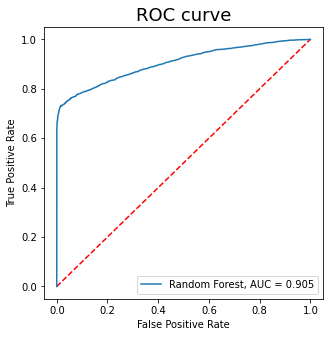

In [630]:
fig = plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1],'r--')
pred_proba = rf.predict_proba(X_test)
probs = pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label=f'Random Forest, AUC = {str(round(auc,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

Accuracy (constant prediction): 0.869
Precision (constant prediction): 0.750
Recall (constant prediction): 0.984


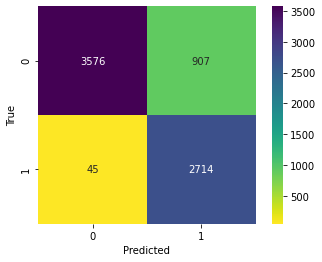

In [661]:
acc = accuracy_score(y_pred, y_test)
prec = precision_score(y_pred, y_test)
rec = recall_score(y_pred, y_test)
print(f'''Accuracy (constant prediction): {acc:.3f}
Precision (constant prediction): {prec:.3f}
Recall (constant prediction): {rec:.3f}''')

cm = confusion_matrix(y_pred, y_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

<AxesSubplot:title={'center':'Feature Importance'}>

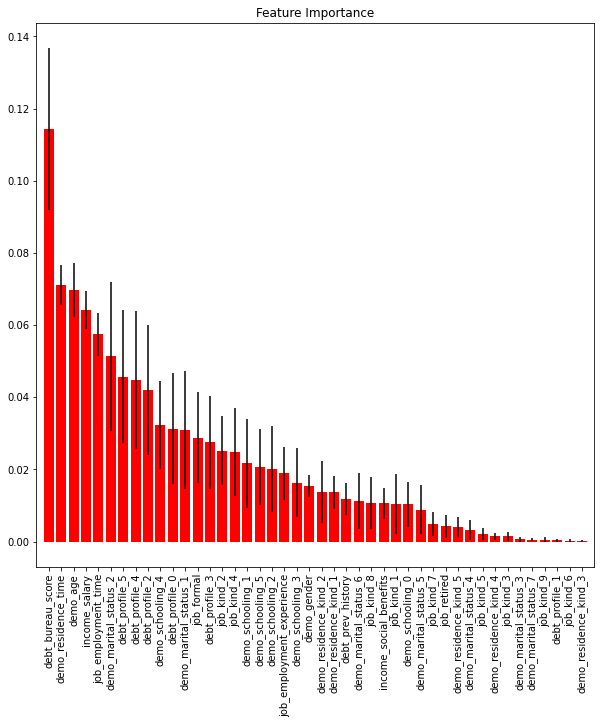

In [682]:
skplt.estimators.plot_feature_importances(rf, feature_names=X_train.columns,x_tick_rotation=90,max_num_features=50,figsize=(10,10))

___
#### XGBOOST

>**SUMMARY**
>
>* The best XGBOOST model had an overall good perfomance with the test set:
>* AUC = 0.913
>* recall (macro) = 0.89
>* f1-score (macro) = 0.87
>* recall (Bad payers) = 0.98

>* The most relevant features to the model were marital_status and debt_profile


In [663]:
## Prepare datasets

# Instantiate balancer
balancer = SMOTE()

# Split train features and labels
X_train = data[data['refdate'] == 8].iloc[:,1:].drop('target',axis=1)
y_train = data[data['refdate'] == 8]['target']

X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Split test features and labels
X_test = data[data['refdate'] == 9].iloc[:,1:].drop('target',axis=1)
y_test = data[data['refdate'] == 9]['target']

# Balance train set
X_train, y_train = balancer.fit_resample(X_train, y_train)
y_train = pd.DataFrame(y_train,columns=['target'])
# Shuffle train set
X_train, y_train, = shuffle(X_train, y_train,random_state=9)

# Balance test set
X_test, y_test = balancer.fit_resample(X_test, y_test)
y_test = pd.DataFrame(y_test,columns=['target'])
# Shuffle Test set
X_test, y_test, = shuffle(X_test, y_test,random_state=9)

In [665]:
# Instantiate a more or less default model
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05,use_label_encoder=False)
xgb.fit(X_train, np.ravel(y_train))
preds = xgb.predict(X_test)
preds_proba = xgb.predict_proba(X_test)
print('                   ', name, '\n',classification_report(y_test, xgb.predict(X_test)))

[20:30:16] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
                    XGB 
               precision    recall  f1-score   support

           0       0.80      0.97      0.88      3621
           1       0.96      0.76      0.85      3621

    accuracy                           0.87      7242
   macro avg       0.88      0.87      0.86      7242
weighted avg       0.88      0.87      0.86      7242



In [618]:
cv_score = cross_val_score(xgb,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Cross Validation recall score: {cv_score}")
print(f"Cross Validation recall mean score: {cv_score.mean()}")

Cross Validation recall score: [0.8125     0.82173064 0.82356771 0.81770833 0.80598958]
Cross Validation recall mean score: 0.8162992538223813


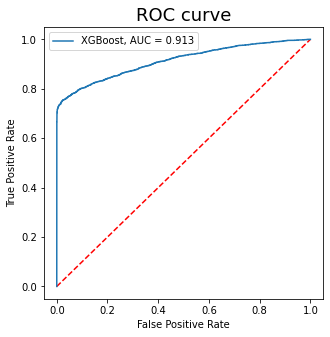

In [496]:
# Plot ROC Curve with AUC Score
fig = plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1],'r--')
pred_proba = xgb.predict_proba(X_test)
probs = pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(auc,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

In [506]:
## RandomizedSearchCV hyperparameter tuning
params = {
    'colsample_bytree': uniform(0.9, 0.1), # 0.9-1 0.9 is the lower bound, 0.1 is the range
    'gamma': uniform(0.2, 0.3),# 0.2-0.5
    'learning_rate': uniform(0.2, 0.2), # 0.2-0.4 
    'max_depth': randint(4, 6), # 4, 5, 6
    'n_estimators': randint(100, 300), # 100-300
    'subsample': uniform(0.9, 0.1), # 0.9-1
    'eval_metric':'error'
}

Random_CV = RandomizedSearchCV(xgb, param_distributions=params, random_state=42, use_label_encoder=False,
                            n_iter=100, cv=3, verbose=2, n_jobs=-1, return_train_score=True)

Random_CV.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[16:41:15] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           enable_categorical=False, gamma=0,
                                           gpu_id=-1, importance_type=None,
                                           interaction_constraints='',
                                           learning_rate=0.300000012,
                                           max_delta_step=0, max_depth=6,
                                           min_child_weight=1, missing=nan,
                                           monotone_constraints='()',
                                           n_estimat...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1448dda30>,
           

In [696]:
## Test timing to fit the model - Total = 10 µs
# %time
# parametros = Random_CV.best_params_
# fit_timing = XGBClassifier(**parametros)
# # fit_timing = teste.get_params(parametros)
# fit_timing.fit(X_train,np.ravel(y_train))


CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 10 µs
[21:14:49] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.930087830981677,
              enable_categorical=False, gamma=0.2854521483132403, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.20737738947090656, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=101, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9502679023228862, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [604]:
# See best params
Random_CV.best_params_

{'colsample_bytree': 0.930087830981677,
 'gamma': 0.2854521483132403,
 'learning_rate': 0.20737738947090656,
 'max_depth': 4,
 'n_estimators': 101,
 'subsample': 0.9502679023228862}

In [ ]:
# Make classification report 
y_pred = Random_CV.best_estimator_.predict(X_test)
xgboost_report = classification_report(y_pred,y_test)
print(classification_report(y_pred,y_test))

In [669]:
cv_score = cross_val_score(Random_CV.best_estimator_,X_train,np.ravel(y_train),cv=5,scoring='recall')
print(f"Cross Validation recall score: {cv_score}")
print(f"Cross Validation recall mean score: {cv_score.mean()}")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:36] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:38] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:39] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:41] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:43] WARNING: /private/var/folders/n6/jlxm1mv508jbbrz2zw40zqnc0000gn/T/pip-install-tjdi0vrq/xgboost_2c4807e6710b4da7a5c8518c400abbbb/build/temp.macosx-10.9-x86_64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Cross Validation recall score: [0.79166667 0.81001952 0.80664062 0.79882812 0.78841146]
Cross Validation recall mean score: 0.7991132787085231


In [612]:
# Save model
pickle.dump(Random_CV.best_estimator_, open("./models/best_XGboost.sav", 'wb'))

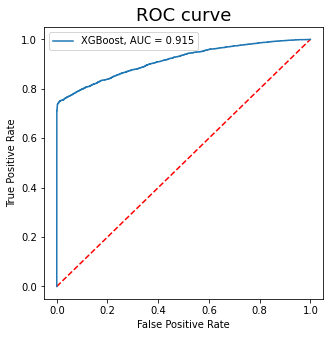

In [609]:
# Plot ROC Curve with AUC Score
fig = plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1],'r--')
pred_proba = Random_CV.best_estimator_.predict_proba(X_test)
probs = pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(auc,3))}')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

Accuracy (constant prediction): 0.869
Precision (constant prediction): 0.750
Recall (constant prediction): 0.984


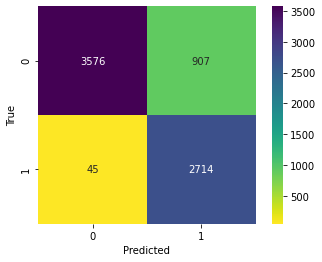

In [660]:
acc = accuracy_score(y_pred,y_test)
prec = precision_score(y_pred,y_test)
rec = recall_score(y_pred,y_test)
print(f'''Accuracy (constant prediction): {acc:.3f}
Precision (constant prediction): {prec:.3f}
Recall (constant prediction): {rec:.3f}''')

cm = confusion_matrix(y_pred, y_test)
ax = sns.heatmap(cm, cmap='viridis_r', annot=True, fmt='d', square=True)
ax.set_xlabel('Predicted')
ax.set_ylabel('True');

<AxesSubplot:title={'center':'Feature Importance'}>

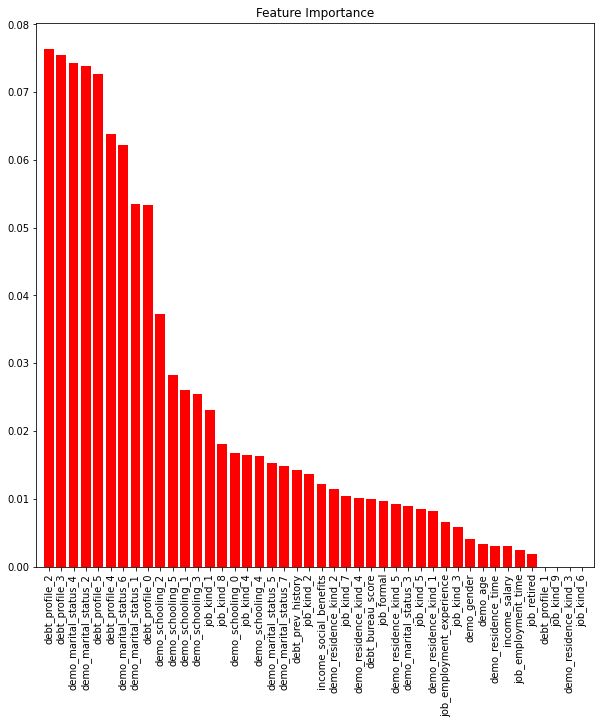

In [585]:
# Get Feature importance
skplt.estimators.plot_feature_importances(model, feature_names=X_train.columns,x_tick_rotation=90,max_num_features=50,figsize=(10,10))

___
#### Compare RF and XGboost models

>**SUMMARY**
>
>* The XGboost model was about slightly superior (~0.02%) in most metrics compared to the RF model
>
>* Both models predicted bad payers equally well

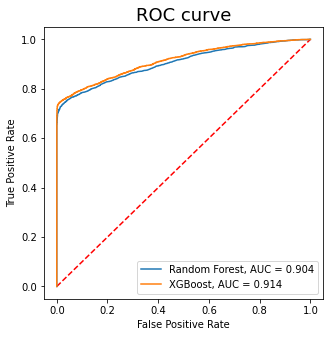

In [588]:
# Compare RF and XGBoost models
#ROC AUC
fig = plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1],'r--')

# RandomForest
pred_proba = rf.predict_proba(X_test)
probs = pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label=f'Random Forest, AUC = {str(round(auc,3))}')

#XGBoost
pred_proba = model.predict_proba(X_test)
probs = pred_proba[:,1]
fpr, tpr, thresh = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)
plt.plot(fpr, tpr, label=f'XGBoost, AUC = {str(round(auc,3))}')

plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC curve")
plt.rcParams['axes.titlesize'] = 18
plt.legend()
plt.show()

In [680]:
# Make classification report 
y_pred = Random_CV.best_estimator_.predict(X_test)
print('XGboost Evaluation\n',xgboost_report)
print('Random Forest Evaluation\n',rf_report)

XGboost Evaluation
               precision    recall  f1-score   support

           0       0.99      0.80      0.88      4477
           1       0.75      0.98      0.85      2765

    accuracy                           0.87      7242
   macro avg       0.87      0.89      0.87      7242
weighted avg       0.90      0.87      0.87      7242

Random Forest Evaluation
               precision    recall  f1-score   support

           0       0.98      0.78      0.87      4545
           1       0.73      0.98      0.84      2697

    accuracy                           0.86      7242
   macro avg       0.86      0.88      0.85      7242
weighted avg       0.89      0.86      0.86      7242

